# Emulate P1D given a cosmological and IGM model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# our modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP

### Load LaCE emulator

In [3]:
# specify simulation suite and P1D mesurements
archive=p1d_archive.archiveP1D()
Na=len(archive.data)
print('P1D archive contains {} entries'.format(Na))

P1D archive contains 330 entries


In [4]:
# specify parameters to be used in emulator
emu_params=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# maximum wavenumber to use in emulator
emu_kmax_Mpc=8
# setup GPy emulator
re_train_emu=True
if re_train_emu:
    emulator=gp_emulator.GPEmulator(paramList=emu_params,passarchive=archive,
                                kmax_Mpc=emu_kmax_Mpc,train=True)
else:
    # we can only load from file the old default (symmetric kernel, including linear term)
    emulator=gp_emulator.GPEmulator(paramList=emu_params,passarchive=archive,
                                kmax_Mpc=emu_kmax_Mpc,train=False,
                                asymmetric_kernel=False,rbf_only=False) 
    emulator.load_default()

Training GP on 330 points


 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 1.25 seconds


### Specify cosmological model

cosmo object will wrap a CAMB results object, and offer useful functionality.

In [5]:
cosmo=camb_cosmo.get_cosmology(H0=67,ns=0.96)

### Compute linear power parameters at the redshift of interest

In [6]:
z=3.0
test_params=fit_linP.get_linP_Mpc_zs(cosmo,zs=[z],kp_Mpc=archive.kp_Mpc)[0]
for key,value in test_params.items():
    print(key,'=',value)

Delta2_p = 0.3591821382675474
n_p = -2.307619271040308
alpha_p = -0.215361074047481
f_p = 0.9813416774057897


### Specify IGM parameters at the redshift

We need to choose a value of mean flux (mF), thermal broadening scale (sigT_Mpc), TDR slope gamma and filtering length (kF_Mpc).

We will choose values that are well sampled in the archive.

In [7]:
dz=0.1
zmask=[ (archive.data[i]['z']<z+dz) & (archive.data[i]['z']>z-dz) for i in range(Na)]

In [8]:
test_params['mF']=np.mean([ archive.data[i]['mF'] for i in range(Na) if zmask[i] ])
print('mean flux = {:.3f}'.format(test_params['mF']))
test_params['sigT_Mpc']=np.mean([ archive.data[i]['sigT_Mpc'] for i in range(Na) if zmask[i] ])
print('thermal broadening sig_T = {:.3f} Mpc'.format(test_params['sigT_Mpc']))
test_params['gamma']=np.mean([ archive.data[i]['gamma'] for i in range(Na) if zmask[i] ])
print('TDR slope gamma = {:.3f}'.format(test_params['gamma']))
test_params['kF_Mpc']=np.mean([ archive.data[i]['kF_Mpc'] for i in range(Na) if zmask[i] ])
print('Filtering length k_F = {:.3f} 1/Mpc'.format(test_params['kF_Mpc']))

mean flux = 0.658
thermal broadening sig_T = 0.128 Mpc
TDR slope gamma = 1.507
Filtering length k_F = 10.746 1/Mpc


### Ask emulator to predict P1D

In [9]:
# specify wavenumbers to emulate (in velocity units)
k_kms=np.logspace(np.log10(0.002),np.log10(0.02),num=20)
# use test cosmology to translate to comoving units
dkms_dMpc=camb_cosmo.dkms_dMpc(cosmo,z)
print('1 Mpc = {:.2f} km/s at z = {}'.format(dkms_dMpc,z))
k_Mpc=k_kms*dkms_dMpc

1 Mpc = 76.67 km/s at z = 3.0


In [10]:
# emulate P1D in comoving units
p1d_Mpc=emulator.emulate_p1d_Mpc(model=test_params,k_Mpc=k_Mpc)
# use test cosmology to translate back to velocity units
p1d_kms=p1d_Mpc*dkms_dMpc

Text(0, 0.5, 'k P(k)')

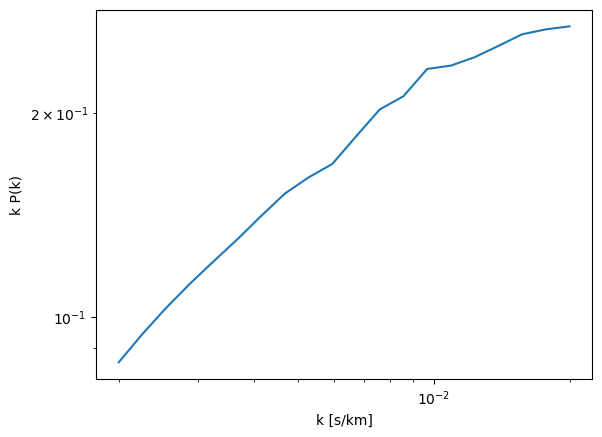

In [11]:
plt.loglog(k_kms,k_kms*p1d_kms)
plt.xlabel('k [s/km]')
plt.ylabel('k P(k)')